In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [4]:
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

# === Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# === Carrega les dades
df = pd.read_csv("parelles.csv").dropna()
examples = [InputExample(texts=[row['text_a'], row['text_b']], label=float(row['label'])) for _, row in df.iterrows()]
train_examples, test_examples = train_test_split(examples, test_size=0.2, random_state=42)

c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0611 22:57:31.638000 4856 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Device: cuda


In [5]:
# Analitza longituds
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("nomic-ai/modernbert-embed-base")
df["len_a"] = df["text_a"].apply(lambda x: len(tokenizer.tokenize(str(x))))
df["len_b"] = df["text_b"].apply(lambda x: len(tokenizer.tokenize(str(x))))
df["max_len"] = df[["len_a", "len_b"]].max(axis=1)
print("Percentil 95 llargada màxima:", df["max_len"].quantile(0.95))


Token indices sequence length is longer than the specified maximum sequence length for this model (8833 > 8192). Running this sequence through the model will result in indexing errors


Percentil 95 llargada màxima: 2604.0


In [6]:
# === Model i loss
model = SentenceTransformer("nomic-ai/modernbert-embed-base")
model.max_seq_length = 512  # no més
model.to(device)
train_loss = losses.ContrastiveLoss(model=model, distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE)

# === Dataloader amb collate
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2, collate_fn=model.smart_batching_collate)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# === Entrenament manual
model.train()
for epoch in range(3):
    total_loss = 0
    for features, labels in tqdm(train_dataloader, desc="Training"):
        # Moure cada diccionari de la llista a GPU
        features = [{k: v.to(device) for k, v in feature.items()} for feature in features]
        labels = labels.to(device)

        optimizer.zero_grad()
        loss = train_loss(features, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        del features, labels, loss
        torch.cuda.empty_cache()

    print(f"Epoch completed. Loss: {total_loss:.4f}")

# === Guarda el model
model.save("output/modernbert-contrastive-manual")


c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(
Training: 100%|██████████| 13309/13309 [1:59:07<00:00,  1.86it/s] 


Epoch completed. Loss: 39.2076


Training: 100%|██████████| 13309/13309 [1:59:16<00:00,  1.86it/s] 


Epoch completed. Loss: 9.6950


Training: 100%|██████████| 13309/13309 [1:58:59<00:00,  1.86it/s] 


Epoch completed. Loss: 4.2547


In [7]:
from sklearn.metrics import roc_auc_score, accuracy_score
from torch.nn.functional import cosine_similarity
import numpy as np

model.eval()

emb1_list = []
emb2_list = []
y_true = []
y_scores = []

with torch.no_grad():
    for example in tqdm(test_examples, desc="Testing"):
        emb1 = model.encode(example.texts[0], convert_to_tensor=True, device=device)
        emb2 = model.encode(example.texts[1], convert_to_tensor=True, device=device)
        sim = cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()

        emb1_list.append(emb1.cpu().numpy())
        emb2_list.append(emb2.cpu().numpy())
        y_true.append(example.label)
        y_scores.append(sim)

# === Mètriques
auc = roc_auc_score(y_true, y_scores)
acc = accuracy_score(y_true, [1 if s > 0.5 else 0 for s in y_scores])

print(f"📈 AUC: {auc:.4f}")
print(f"✅ Accuracy (umbral 0.5): {acc:.4f}")


Testing: 100%|██████████| 6655/6655 [09:09<00:00, 12.12it/s]

📈 AUC: 0.9999
✅ Accuracy (umbral 0.5): 0.9898


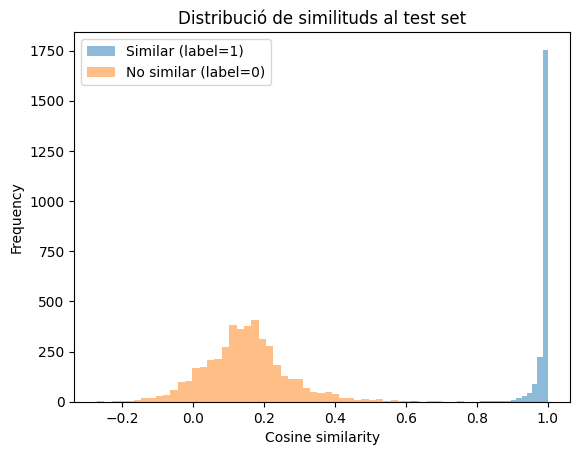

In [8]:
import matplotlib.pyplot as plt

plt.hist([s for s, y in zip(y_scores, y_true) if y == 1], bins=50, alpha=0.5, label="Similar (label=1)")
plt.hist([s for s, y in zip(y_scores, y_true) if y == 0], bins=50, alpha=0.5, label="No similar (label=0)")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribució de similituds al test set")
plt.show()


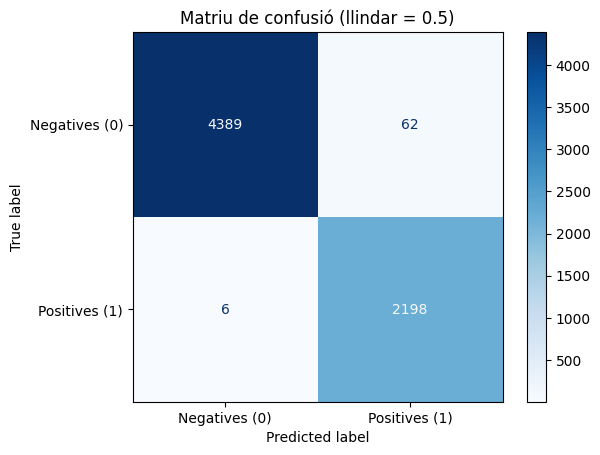

🔢 Valors:
TN (negatives correctes): 4389
FP (falsos positius):     62
FN (falsos negatius):     6
TP (positives correctes): 2198


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ───────────────────────────────────────────────────
# Tria un llindar per fer classificació binària
llindar = 0.5  # ajustable

# Generem prediccions: si similitud > llindar → positiva
prediccions = [1 if s >= llindar else 0 for s in y_scores]

# ───────────────────────────────────────────────────
# Matriu de confusió
cm = confusion_matrix(y_true, prediccions)
labels = ["Negatives (0)", "Positives (1)"]

# Mostrem matriu
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title(f"Matriu de confusió (llindar = {llindar})")
plt.show()

# També mostrem les xifres
tn, fp, fn, tp = cm.ravel()
print("🔢 Valors:")
print(f"TN (negatives correctes): {tn}")
print(f"FP (falsos positius):     {fp}")
print(f"FN (falsos negatius):     {fn}")
print(f"TP (positives correctes): {tp}")


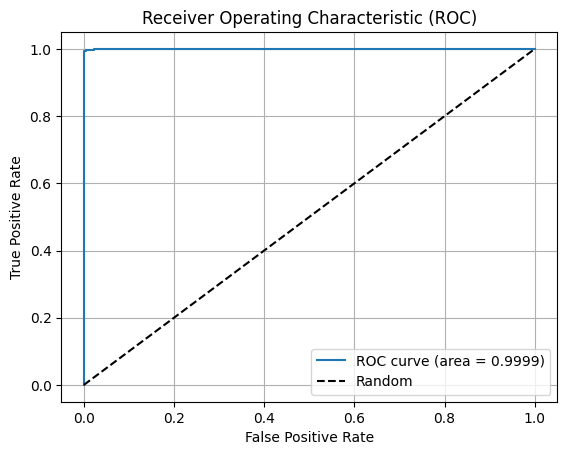

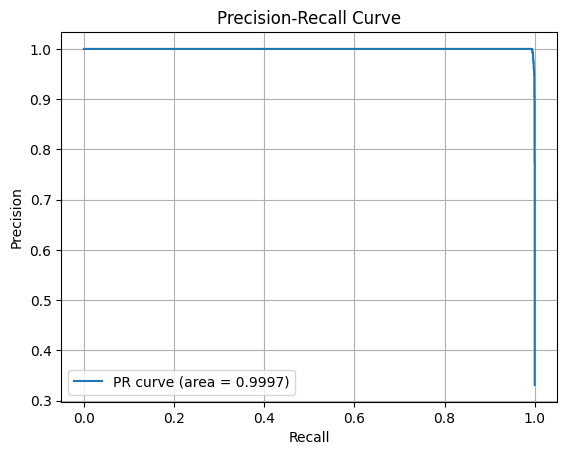

In [10]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR curve (area = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()


In [11]:
emb1_array = np.vstack(emb1_list)
emb2_array = np.vstack(emb2_list)
y_true = np.array(y_true)
y_scores = np.array(y_scores)
y_pred = (y_scores > 0.5).astype(int)


In [12]:
correct_mask = y_pred == y_true
incorrect_mask = y_pred != y_true


In [13]:
# Troba la primera parella ben classificada
idx_correct = np.where(correct_mask)[0][0]
print("Exemple BEN classificat:")
print("Text A:", test_examples[idx_correct].texts[0])
print("Text B:", test_examples[idx_correct].texts[1])
print("Label real:", y_true[idx_correct], "Predicció:", y_pred[idx_correct], "Similitud:", y_scores[idx_correct])
print("Embedding A:", emb1_array[idx_correct][:10], "...")  # Mostrem només els primers valors per espai
print("Embedding B:", emb2_array[idx_correct][:10], "...")

# Troba la primera parella MAL classificada
idx_incorrect = np.where(incorrect_mask)[0][0]
print("\nExemple MAL classificat:")
print("Text A:", test_examples[idx_incorrect].texts[0])
print("Text B:", test_examples[idx_incorrect].texts[1])
print("Label real:", y_true[idx_incorrect], "Predicció:", y_pred[idx_incorrect], "Similitud:", y_scores[idx_incorrect])
print("Embedding A:", emb1_array[idx_incorrect][:10], "...")
print("Embedding B:", emb2_array[idx_incorrect][:10], "...")


Exemple BEN classificat:
Text A: The ratio $R_\mathrm{c}$ of the cluster interaction SCS to the overall SCS and the minimum single-scatterer SCS, $\mathrm{R}_{\mathrm{min}}$, satisfy %              R_\mathrm{c}\leq\min\left\{\frac{N-1}{N},1-N\mathrm{R}_{\mathrm{min}}\right\}.      %
Text B: It holds that                   \mathrm{R}_{\mathrm{max}}=\frac{1}{N^2}         if and only if                      \mathrm{R}_{n}=\frac{1}{N^2},\quad \mbox{\rm{for all}} \quad n=1,\ldots,N.      %
Label real: 1.0 Predicció: 1 Similitud: 0.8756859302520752
Embedding A: [-0.03195788  0.05906368  0.00644743 -0.06837729 -0.03461587 -0.00363929
  0.0135205   0.02898979 -0.01595688  0.02857438] ...
Embedding B: [ 0.00228453  0.05675765  0.03442452 -0.04510061 -0.04104726 -0.0261019
 -0.00669854  0.02357217 -0.00199207  0.04701463] ...

Exemple MAL classificat:
Text A: Let us provide a simple example to show the advantage of our extension over the  Micchelli-Chen-Xu's approach. Let $\mathcal{M}=\partial \

In [56]:
print(idx_incorrect)

34


In [43]:
import pandas as pd

# Extraiem els índexs de les prediccions incorrectes
incorrect_indices = np.where(incorrect_mask)[0]

# Preparem les dades per guardar
rows = []
for idx in incorrect_indices:
    rows.append({
        "text_a": test_examples[idx].texts[0],
        "text_b": test_examples[idx].texts[1],
        "label_real": y_true[idx],
        "prediccio": y_pred[idx],
        "similitud": y_scores[idx]
    })

# Creem el DataFrame i el guardem
df_errors = pd.DataFrame(rows)
df_errors.to_csv("parelles_mal_classificades.csv", index=False)


In [14]:
import umap

# Ex: UMAP de la suma dels embeddings
emb_sum = emb1_array + emb2_array
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
proj = umap_model.fit_transform(emb_sum)


c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [15]:
model.eval()

y_true_train = []
y_scores_train = []

with torch.no_grad():
    for example in tqdm(train_examples, desc="Evaluando en TRAIN"):
        emb1 = model.encode(example.texts[0], convert_to_tensor=True, device=device)
        emb2 = model.encode(example.texts[1], convert_to_tensor=True, device=device)
        sim = cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()
        y_true_train.append(example.label)
        y_scores_train.append(sim)

# Métricas en TRAIN
auc_train = roc_auc_score(y_true_train, y_scores_train)
acc_train = accuracy_score(y_true_train, [1 if s > 0.5 else 0 for s in y_scores_train])

print(f"TRAIN AUC: {auc_train:.4f}")
print(f"TRAIN Accuracy (umbral 0.5): {acc_train:.4f}")


Evaluando en TRAIN: 100%|██████████| 26618/26618 [36:53<00:00, 12.02it/s] 

TRAIN AUC: 1.0000
TRAIN Accuracy (umbral 0.5): 0.9943


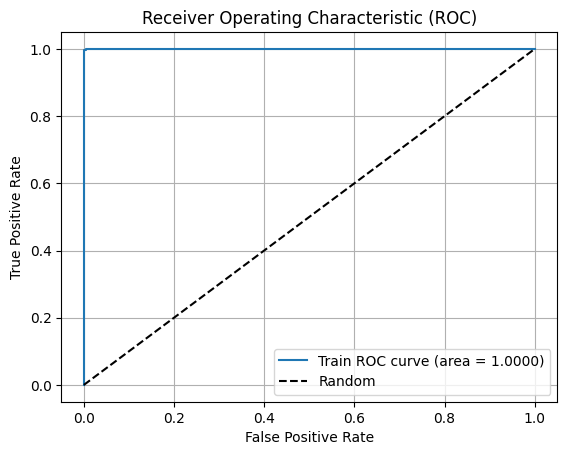

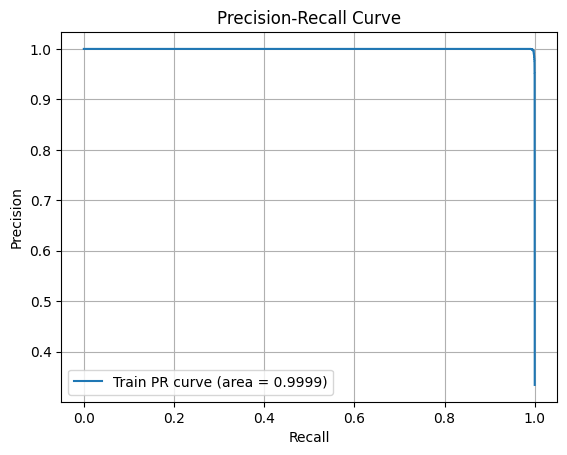

In [16]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_true_train, y_scores_train)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Train ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true_train, y_scores_train)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"Train PR curve (area = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()


In [47]:
# Carrega chunks
chunks = pd.concat([df['text_a'], df['text_b']]).drop_duplicates().reset_index(drop=True)
df_chunks = pd.DataFrame({'chunk_text': chunks})


In [48]:
from sentence_transformers import SentenceTransformer

# Carrega model preentrenat i fine-tuned
model_pre = SentenceTransformer("nomic-ai/modernbert-embed-base")
model_ft = SentenceTransformer("output/modernbert-contrastive-manual")

# Agafa tots els texts a visualitzar
texts = df_chunks['chunk_text'].tolist()

model_pre.max_seq_length = 512
emb_pre = model_pre.encode(
    texts, 
    convert_to_numpy=True, 
    show_progress_bar=True, 
    device="cuda",
)

model_ft.max_seq_length = 512
emb_ft = model_ft.encode(
    texts, 
    convert_to_numpy=True, 
    show_progress_bar=True, 
    device="cuda"
)


Batches: 100%|██████████| 55/55 [33:16<00:00, 36.30s/it]


In [51]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
proj_pre = umap_model.fit_transform(emb_pre)
proj_ft = umap_model.fit_transform(emb_ft)



c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [20]:
df_chunks.head()

,chunk_text
0,We define approximate peak time $t^{p}_0$ by t...
1,Let $\ell=100 \; {\rm ps}$. Supposing that $x...
2,"Let $x_d, \; x_s\in\partial\Omega$, and assume..."
3,We first study the asymptotic behavior of the ...
4,The approximate peak time for a small fluoresc...


In [21]:
df_blocks = pd.read_csv("df_blocks.csv")


In [22]:
df_chunks = df_chunks.merge(
    df_blocks,
    left_on="chunk_text",
    right_on="content",   # on el text és idèntic
    how="left"
)
# Pots quedar-te amb les columnes que vulguis:
df_chunks = df_chunks[["chunk_text", "type", "article_id"]]


In [23]:
df_chunks.head()

,chunk_text,type,article_id
0,We define approximate peak time $t^{p}_0$ by t...,definition,2502.01037
1,Let $\ell=100 \; {\rm ps}$. Supposing that $x...,example,2502.01037
2,"Let $x_d, \; x_s\in\partial\Omega$, and assume...",lemma,2502.01037
3,We first study the asymptotic behavior of the ...,proof,2502.01037
4,The approximate peak time for a small fluoresc...,theorem,2502.01037


In [24]:
print(len(labels), proj_pre.shape, proj_ft.shape)


2 (1757, 2) (1757, 2)


In [25]:
# Només els que tenen article_id vàlid i que existeixen als embeddings
mask_valid = df_chunks['article_id'].notna().values[:proj_pre.shape[0]]

labels = df_chunks.loc[:proj_pre.shape[0]-1, 'article_id'][mask_valid].astype(str).reset_index(drop=True)
proj_pre_valid = proj_pre[mask_valid]
proj_ft_valid = proj_ft[mask_valid]


In [26]:
print(len(labels), proj_pre.shape, proj_ft.shape)


1757 (1757, 2) (1757, 2)


In [ ]:
import numpy as np
import pandas as pd

# Suposem que tens:
# - df_chunks: DataFrame amb tants files com embeddings (ex: 1757 files, amb chunk_text, article_id, etc)
# - proj_pre, proj_ft: arrays (N, 2) d'embeddings UMAP

# Primer, només selecciona els primers N files de df_chunks (on N = proj_pre.shape[0])
N = proj_pre.shape[0]
df_plot = df_chunks.iloc[:N].copy()

# Si vols garantir que no hi ha NaN a article_id:
mask_valid = df_plot['article_id'].notna()
df_plot = df_plot.loc[mask_valid].reset_index(drop=True)
proj_pre_valid = proj_pre[mask_valid.values]
proj_ft_valid = proj_ft[mask_valid.values]

C:\Users\MGestioTI\AppData\Local\Temp\ipykernel_4856\2893868661.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # O 'tab20' si tens molts tipus


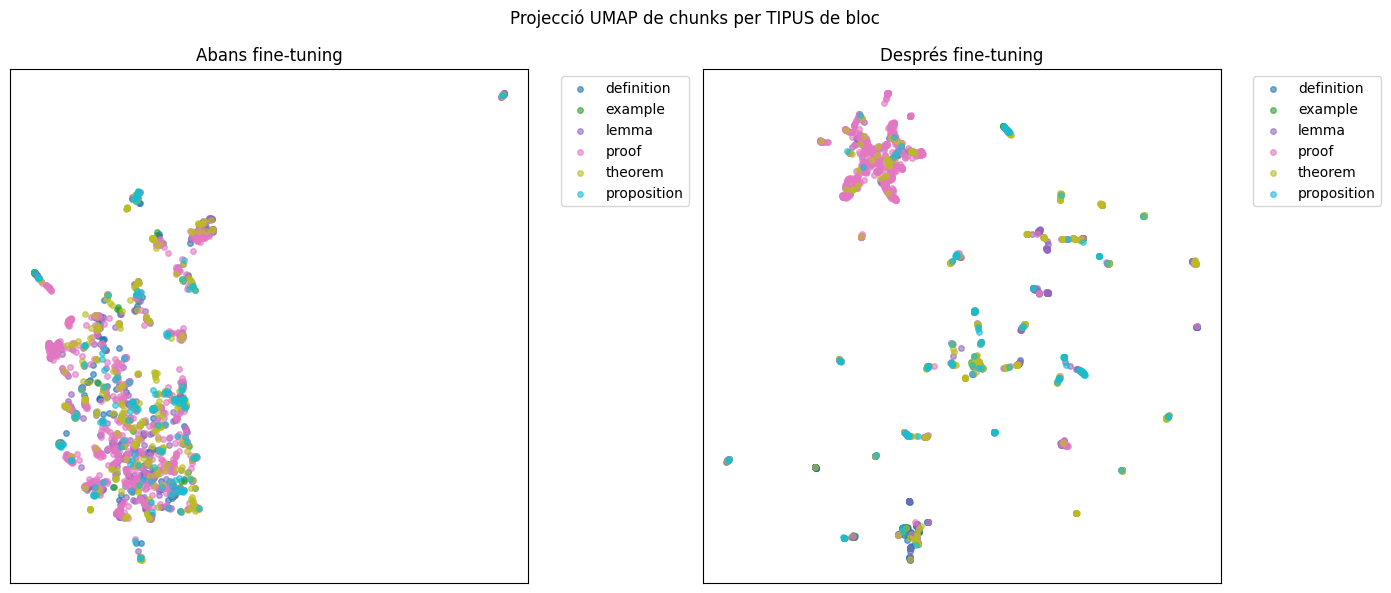

In [45]:
labels = df_plot['type'].astype(str)
unique_labels = labels.unique()
colors = plt.cm.get_cmap('tab10', len(unique_labels))  # O 'tab20' si tens molts tipus

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, (proj, title) in enumerate(zip([proj_pre_valid, proj_ft_valid], ['Abans fine-tuning', 'Després fine-tuning'])):
    for idx, label in enumerate(unique_labels):
        mask = labels == label
        axes[i].scatter(proj[mask, 0], proj[mask, 1], label=label, alpha=0.6, s=16, color=colors(idx))
    axes[i].set_title(title)
    axes[i].legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.suptitle('Projecció UMAP de chunks per TIPUS de bloc')
plt.tight_layout()
plt.show()


In [31]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("output/modernbert-contrastive-manual")
model.max_seq_length = 512  # Límita a 512 tokens


In [32]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

#  Fes servir la GPU (device='gpu')
emb_a = model.encode(df_test['text_a'].tolist(), convert_to_numpy=True, device='cuda', batch_size=2, show_progress_bar=True)
emb_b = model.encode(df_test['text_b'].tolist(), convert_to_numpy=True, device='cuda', batch_size=2, show_progress_bar=True)


Batches: 100%|██████████| 3328/3328 [02:57<00:00, 18.71it/s]


In [33]:
import umap.umap_ as umap

# Ex: sumar els embeddings de cada parella (hi ha moltes opcions: resta, concat, etc)
emb_parelles = emb_a + emb_b

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
proj = umap_model.fit_transform(emb_parelles)


c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


c:\Users\MGestioTI\Desktop\tfg\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [34]:
import numpy as np

def cosine_sim(a, b):
    # a, b = arrays (n, d)
    return np.sum(a * b, axis=1) / (np.linalg.norm(a, axis=1) * np.linalg.norm(b, axis=1))

sims = cosine_sim(emb_a, emb_b)
df_test['prediccio'] = (sims > 0.5).astype(int)  # Umbral de 0.5, igual que l'avaluació


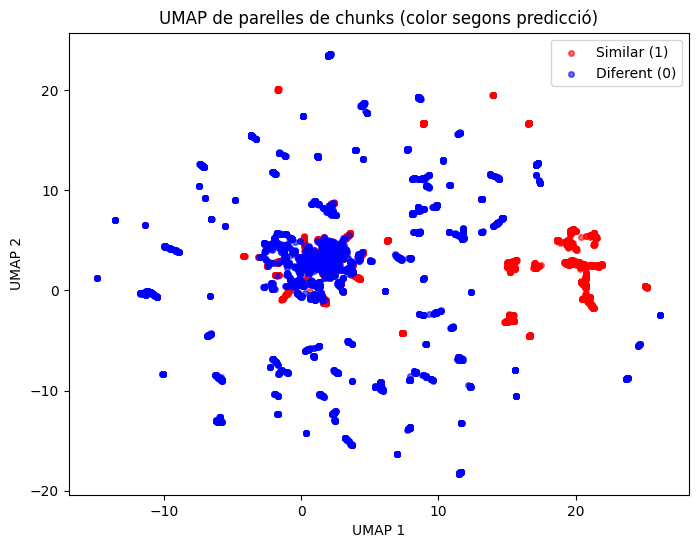

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(proj[df_test['prediccio'] == 1, 0], proj[df_test['prediccio'] == 1, 1], 
            c='red', label='Similar (1)', alpha=0.6, s=16)
plt.scatter(proj[df_test['prediccio'] == 0, 0], proj[df_test['prediccio'] == 0, 1], 
            c='blue', label='Diferent (0)', alpha=0.6, s=16)
plt.legend()
plt.title('UMAP de parelles de chunks (color segons predicció)')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


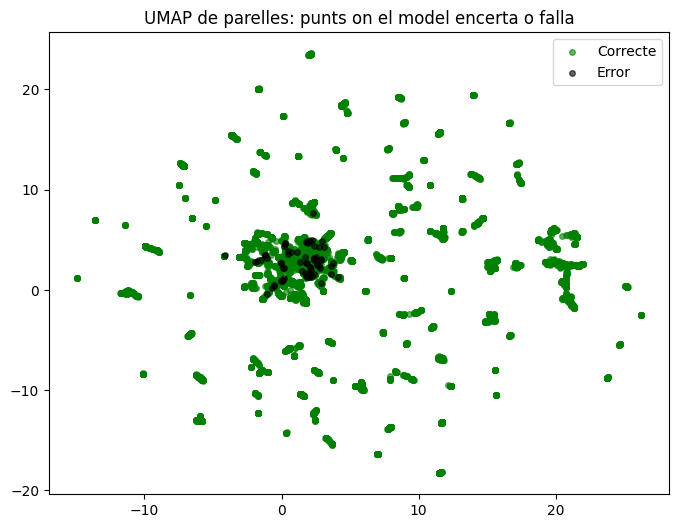

In [37]:
# Ex: df_parelles['label_real'] = la columna amb el label real

plt.figure(figsize=(8, 6))
mask_ok = df_test['prediccio'] == df_test['label']
plt.scatter(proj[mask_ok, 0], proj[mask_ok, 1], c='green', label='Correcte', alpha=0.6, s=16)
plt.scatter(proj[~mask_ok, 0], proj[~mask_ok, 1], c='black', label='Error', alpha=0.6, s=16)
plt.legend()
plt.title('UMAP de parelles: punts on el model encerta o falla')
plt.show()


In [40]:
df_test

,Unnamed: 0,text_a,text_b,label,len_a,len_b,max_len,prediccio
8880,8880,The ratio $R_\mathrm{c}$ of the cluster intera...,It holds that \mathrm{R}_{\m...,1,80,63,80,1
12976,12976,}{\hfill \interlinepenalty500 $\Box$,"From Lemma \ref{lemqfu}, it follows that: \t ...",0,12,537,537,0
1243,1243,[Sobolev lemma] \tFor any $f(x)\in H^2(\Omega_...,For any $\alpha_h\in(\mathbb{Z}_{\geqslant 0})...,1,80,244,244,1
1255,1255,[Properties of weights] For any $\sigma\in ...,For any $\alpha_h\in(\mathbb{Z}_{\geqslant 0})...,1,563,142,563,1
23578,23578,"Along with hypotheses \ref{a6}, suppose the fo...","By Lemma~\ref{lem:coloring K5}, for every $1 ...",0,199,227,227,0
...,...,...,...,...,...,...,...,...
15756,15756,"Fix $\ell_1,\ell_2 \in \mathbb N$. For $n\geq ...",Let $G$ be a $k$-planar graph with $n$ vertice...,0,177,252,252,0
22806,22806,"Let $X\in \Sm/k$ be a cellular scheme, let $V\...",[Berry’s random wave property] Let $\Omega...,0,112,179,179,0
31829,31829,"Let $(\ell_1,\ldots,\ell_m)\in \mathbb N^m$, w...",As summarized in Proposition \ref{prop:Avantag...,0,194,438,438,0
30249,30249,[Proof of Theorem D] Choose a precompact and c...,\cite[Theorems 1-2-4]{li15} Let us suppose tha...,0,1815,85,1815,0


In [41]:
# A df tens: text_a, text_b, label, prediccio, (altres...)
errors = df_test[df_test['prediccio'] != df_test['label']]

# Veure les primeres files d'errors
print(errors[['text_a', 'text_b', 'label', 'prediccio']].head(10))


                                                  text_a  \
13538  Let us provide a simple example to show the ad...   
32025  [Approximation bound for  CNN] \t\tWith the sa...   
14533  [Sequential composition of maps] Let $\Phi:Q_1...   
10128  For any set $\Delta\subseteq\Omega$, we can fi...   
13099  Let $2\leq k\leq 3$ and $1\leq a_1\leq \ldots ...   
32828  [No $\mathring{H}^2$-conforming quadratics]  %...   
29186  The approximate peak time for a large fluoresc...   
25955  Let $d$ be a thin $\mc{P}_\ka(\la)$ list in $V...   
25957  For $s \in \mathbb{C}$ away from the poles of ...   
11570  The positive solution $t_0>0$ to   - k  - \fra...   

                                                  text_b  label  prediccio  
13538  Denote the set of equivalence classes generate...      0          1  
32025  The second moment of this activation is:   \ma...      0          1  
14533  Consider a sequence $\{T_i\}_{i > 0}$ of opera...      0          1  
10128  [\cite{BabaiSzemeredi198

In [52]:
print(len(errors))

68


In [57]:
errors.head()

,Unnamed: 0,text_a,text_b,label,len_a,len_b,max_len,prediccio
13538,13538,Let us provide a simple example to show the ad...,Denote the set of equivalence classes generate...,0,1187,105,1187,1
32025,32025,[Approximation bound for CNN] \t\tWith the sa...,The second moment of this activation is: \ma...,0,272,94,272,1
14533,14533,[Sequential composition of maps] Let $\Phi:Q_1...,Consider a sequence $\{T_i\}_{i > 0}$ of opera...,0,183,148,183,1
10128,10128,"For any set $\Delta\subseteq\Omega$, we can fi...","[\cite{BabaiSzemeredi1984}] For $j>1$, the...",1,83,123,123,0
13099,13099,Let $2\leq k\leq 3$ and $1\leq a_1\leq \ldots ...,[Existence and uniqueness \cite{HofmeisterThes...,0,102,53,102,1
